In [47]:
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import pandas as pd

# Check if Crab can be observed simultaneously from Ondrejov (Czeck Rep.) and from Hanle (India)

In [48]:
# Setting up directories and files
for fold2 in ['/hanle','/ondrejov']:
    path = ''
    for fold in ['../output','/Visibility']:
        path += fold
        Path(path).mkdir(exist_ok=True)
    path += fold2
    Path(path).mkdir(exist_ok=True)
output_ond = os.fspath(Path('../output/Visibility/ondrejov/.').resolve()) + '/'
output_han = os.fspath(Path('../output/Visibility/hanle/.').resolve()) + '/'
loc_ondrejov = os.fspath(Path('../config/location_ondrejov.txt').resolve())
loc_hanle = os.fspath(Path('../config/location_hanle.txt').resolve())
env_ondrejov = os.fspath(Path('../config/environmental_limitation_ondrejov.txt').resolve())
env_hanle = os.fspath(Path('../config/environmental_limitation_hanle.txt').resolve())

'''
# Setting up directories
p = Path('..')
o = p / 'output'
Path(o).mkdir(exist_ok=True)
out = p / 'output' / 'Visibility/.'
Path(out).mkdir(exist_ok=True)
out_han = p / 'output' / 'Visibility' / 'hanle/.'
if not out_han.exists():
    out_han.mkdir()
out_ond = p / 'output' / 'Visibility' / 'ondrejov/.'
if not out_ond.exists():
    out_ond.mkdir()
json_file_name = p / 'catalog' / 'crab.json'
loc_ondrejov = p / 'config' / 'location_ondrejov.txt'
env_ondrejov = p / 'config' / 'environmental_limitation_ondrejov.txt'
loc_hanle = p / 'config' / 'location_hanle.txt'
env_hanle = p / 'config' / 'environmental_limitation_hanle.txt'

output_ond = os.fspath(out_ond.resolve()) + '/'
output_han = os.fspath(out_han.resolve()) + '/'
json_file_name = os.fspath(json_file_name.resolve())
loc_ondrejov = os.fspath(loc_ondrejov.resolve())
env_ondrejov = os.fspath(env_ondrejov.resolve())
loc_hanle = os.fspath(loc_hanle.resolve())
env_hanle = os.fspath(env_hanle.resolve())
'''

"\n# Setting up directories\np = Path('..')\no = p / 'output'\nPath(o).mkdir(exist_ok=True)\nout = p / 'output' / 'Visibility/.'\nPath(out).mkdir(exist_ok=True)\nout_han = p / 'output' / 'Visibility' / 'hanle/.'\nif not out_han.exists():\n    out_han.mkdir()\nout_ond = p / 'output' / 'Visibility' / 'ondrejov/.'\nif not out_ond.exists():\n    out_ond.mkdir()\njson_file_name = p / 'catalog' / 'crab.json'\nloc_ondrejov = p / 'config' / 'location_ondrejov.txt'\nenv_ondrejov = p / 'config' / 'environmental_limitation_ondrejov.txt'\nloc_hanle = p / 'config' / 'location_hanle.txt'\nenv_hanle = p / 'config' / 'environmental_limitation_hanle.txt'\n\noutput_ond = os.fspath(out_ond.resolve()) + '/'\noutput_han = os.fspath(out_han.resolve()) + '/'\njson_file_name = os.fspath(json_file_name.resolve())\nloc_ondrejov = os.fspath(loc_ondrejov.resolve())\nenv_ondrejov = os.fspath(env_ondrejov.resolve())\nloc_hanle = os.fspath(loc_hanle.resolve())\nenv_hanle = os.fspath(env_hanle.resolve())\n"

In [49]:
src_list = ['Crab','Mrk421','Mrk501','CTA1','Dragonfly','Geminga','Cygnus']

In [50]:
# Please select source index from 'src_list'. From CTA1 onward catalogues are not yet existing. TBD
ind = 1
src = src_list[ind]
json_file_name = os.fspath(Path(f'../catalog/{src}.json').resolve())
json_file_name

'/Users/bowe46/WORK/SST-1M/ALL_repo/Observation_plan_maker/catalog/Mrk421.json'

In [51]:
def run_digicam_scheduling(start_date, end_date, output, loc, catalog_json, environment_filename, time_step=5):
    '''
    end_date : ...
    '''
    !digicamscheduling-elevation --start_date=$start_date --end_date=$end_date --time_step $time_step --output_path $output --location_filename $loc --sources_filename $catalog_json --use_moon --environment_filename $environment_filename
    return

In [52]:
def read_visibility_csv(folder,filename='Crab2025-01-15T12-00-00.0002025-01-16T12-00-00.000_visibility.csv'):
    file = folder + filename
    return pd.read_csv(file, parse_dates=['date'])

In [53]:
def get_time_range_above_elevation(data_ondrejov,data_hanle,elevation=40):
    d_han = data_hanle[data_hanle['elevation'] > elevation]
    d_ond = data_ondrejov[data_ondrejov['elevation'] > elevation]
    if len(d_han) > 0 and len(d_ond) > 0:
        start_time = max(d_ond.date[d_ond.index[0]],d_han.date[d_han.index[0]])
        end_time = min(d_ond.date[d_ond.index[-1]],d_han.date[d_han.index[-1]])
        if start_time > end_time:
            return None, None, pd.Timedelta(0)
        return start_time, end_time, end_time - start_time
    else:
        return None, None, pd.Timedelta(0)

In [56]:
def make_plot(src,data_ond,data_han,year,month,day):
    fig,ax = plt.subplots()
    ax.set_title(f'Simultaneous visibility of source {src}')
    ax.set_xlabel('Time [UTC]')
    ax.set_ylabel('Elevation [deg]')
    data_han.plot('date','elevation',ax=ax,label='hanle')
    data_ond.plot('date','elevation',ax=ax,label='ondrejov')
    ax.set_ylim(0,90)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    start_40, end_40, duration_40 = get_time_range_above_elevation(data_ondrejov=data_ond,data_hanle=data_han,elevation=40)
    start_50, end_50, duration_50 = get_time_range_above_elevation(data_ondrejov=data_ond,data_hanle=data_han,elevation=50)

    if (start_40 is not None) and (end_40 is not None):
        ax.fill_between(xlim,40,color='r',alpha=0.2)
        ax.fill_betweenx(ylim,start_40,color='k',alpha=0.2)
        ax.fill_betweenx(ylim,end_40,x2=max(xlim),color='k',alpha=0.2)
        ax.axvline(start_40,ylim[0],ylim[1],ls='-',c='k')
        ax.axvline(end_40,ylim[0],ylim[1],ls='-',c='k')
    else:
        ax.fill_between(xlim,40,color='r',alpha=0.2)
        ax.fill_between(xlim,50,color='r',alpha=0.2)
        ax.fill_betweenx(ylim,max(xlim),color='k',alpha=0.2)

    if (start_50 is not None) and (end_50 is not None):
        ax.fill_between(xlim,50,color='r',alpha=0.2)
        ax.axvline(start_50,ylim[0],ylim[1],ls='--',c='k')
        ax.axvline(end_50,ylim[0],ylim[1],ls='--',c='k')
    
    ax.text(0.67, 0.8, 'Time above elevation:', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    hours, remainder = divmod(duration_40.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    ax.text(0.67, 0.75, f'>40° = {hours}h {minutes}m', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    hours, remainder = divmod(duration_50.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    ax.text(0.67, 0.7, f'>50° = {hours}h {minutes}m', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    fig.tight_layout()
    Path('../output/simultaneous_visibility').mkdir(exist_ok=True)
    Path(f'../output/simultaneous_visibility/{src}').mkdir(exist_ok=True)
    fig_name = Path(f'../output/simultaneous_visibility/{src}') / f'{src}_{year:4d}-{month:02d}-{day:02d}.png'
    fig.savefig(fig_name)
    return

        Use get_body("moon") instead. [digicamscheduling.core.moon]
Source: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
        Use get_body("moon") instead. [digicamscheduling.core.moon]
Source: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
2025-1-1 done
        Use get_body("moon") instead. [digicamscheduling.core.moon]
Source: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
        Use get_body("moon") instead. [digicamscheduling.core.moon]
Source: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
2025-1-5 done
        Use get_body("moon") instead. [digicamscheduling

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bowe46/WORK/SST-1M/ALL_repo/Observation_plan_maker/output/Visibility/ondrejov/Mrk421_2025-04-10T12-00-00.0002025-04-11T12-00-00.000_visibility.csv'

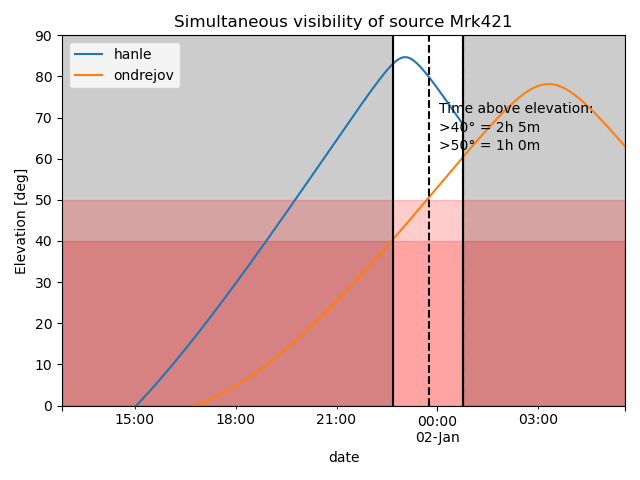

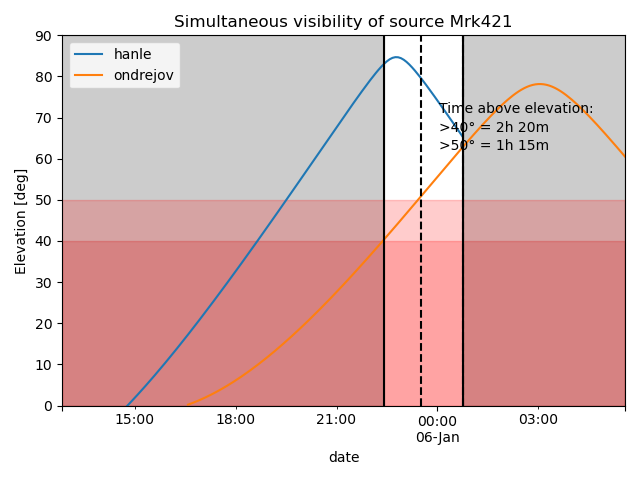

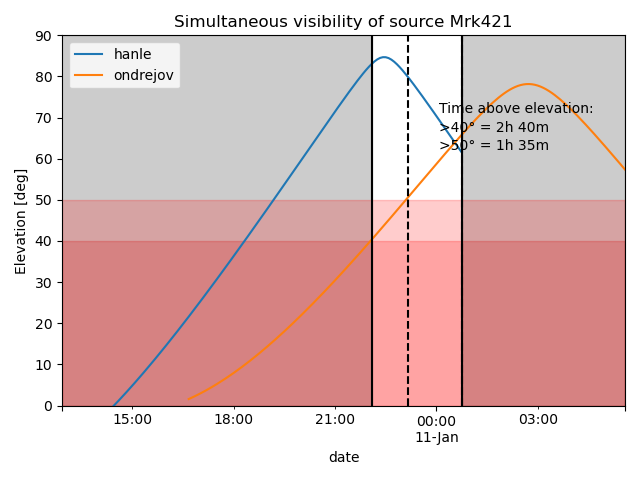

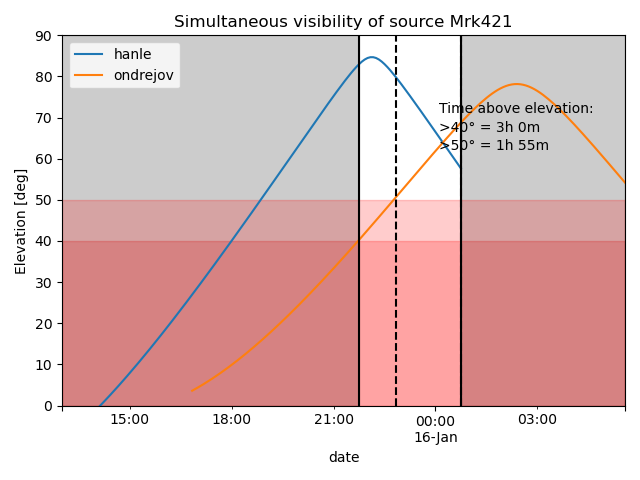

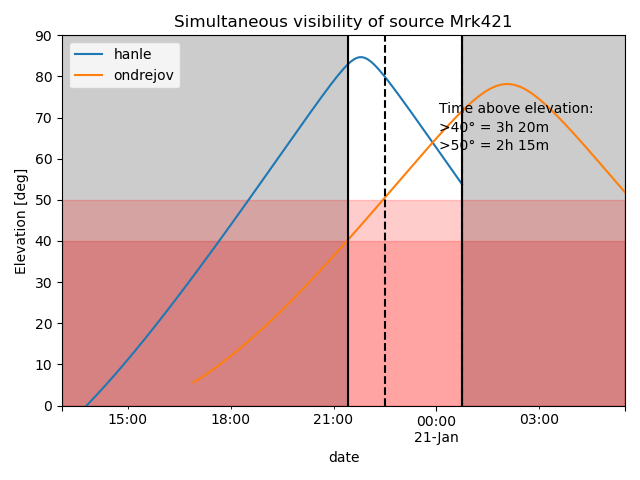

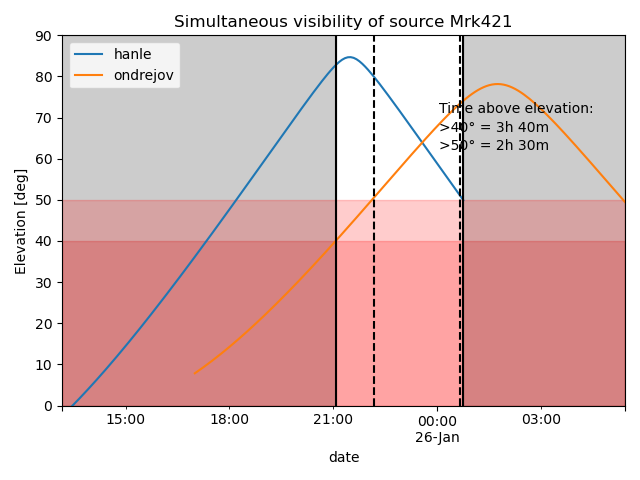

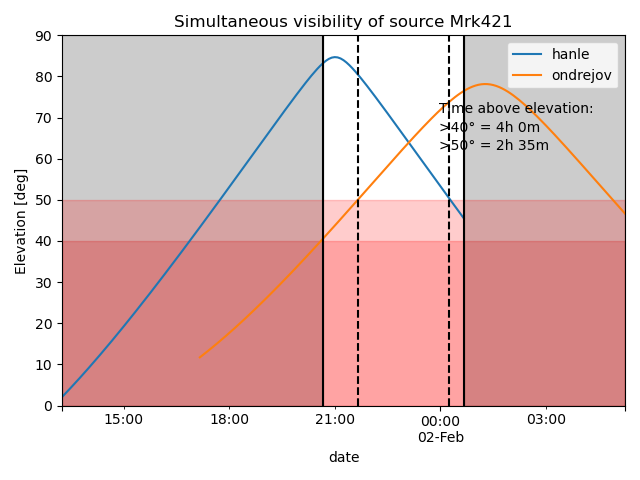

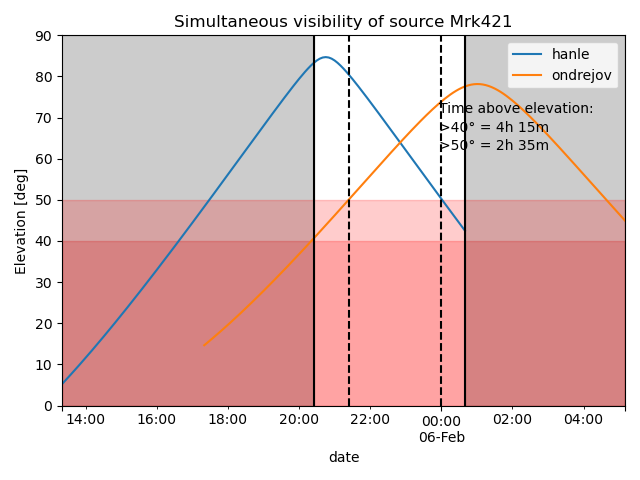

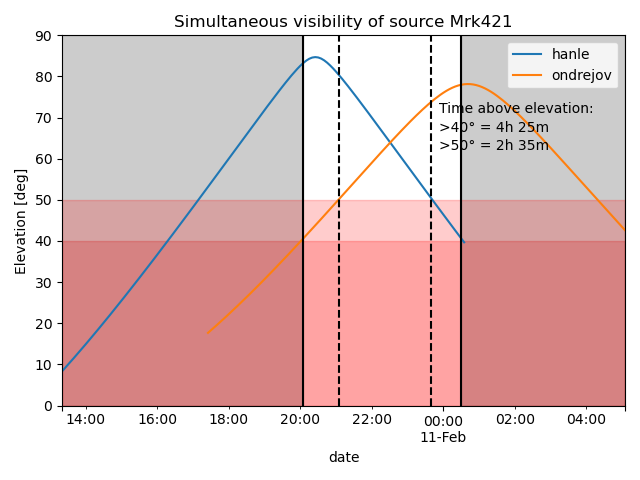

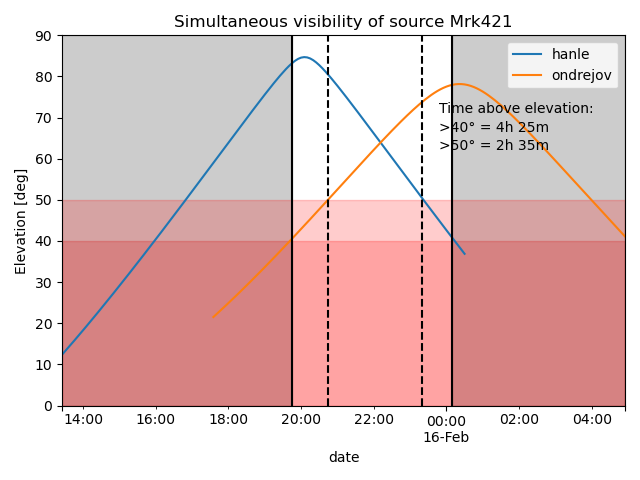

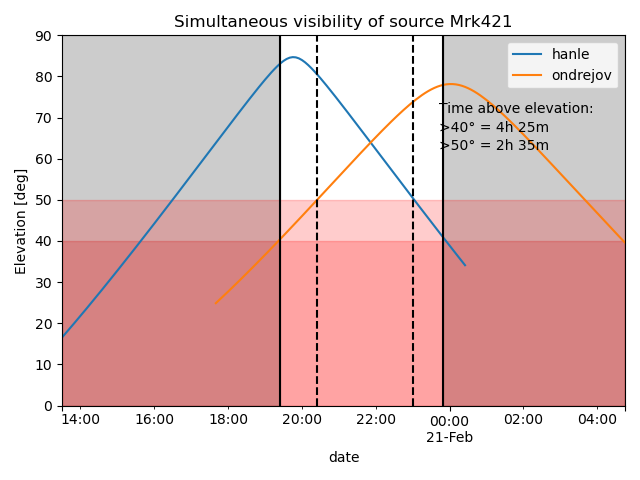

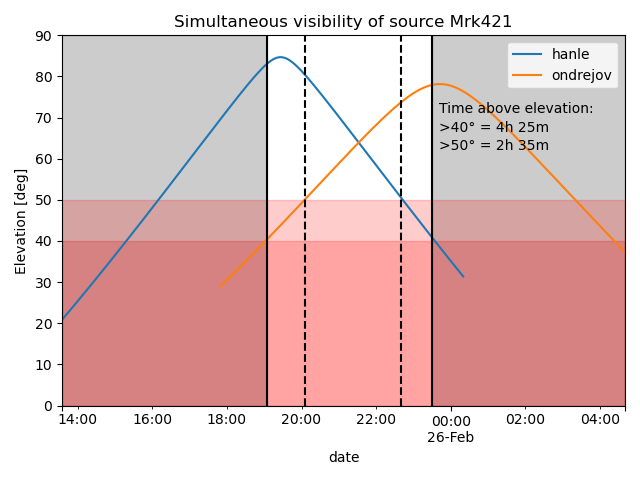

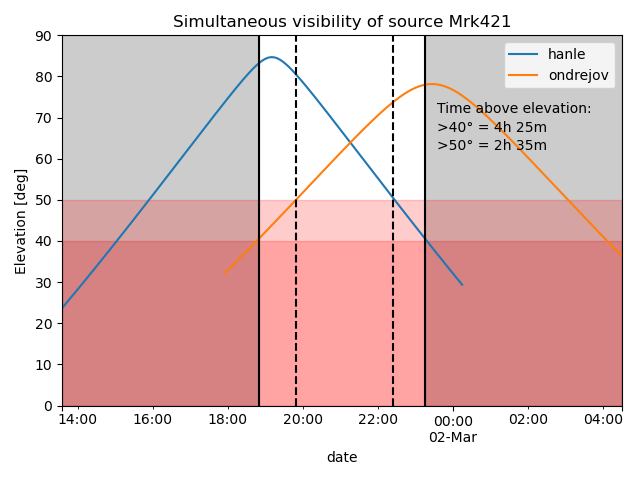

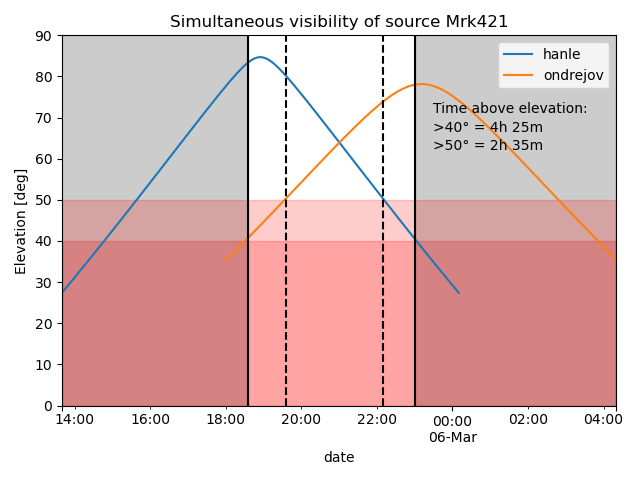

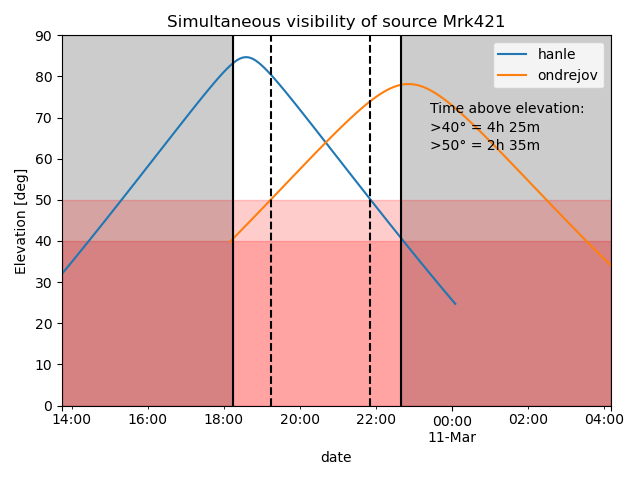

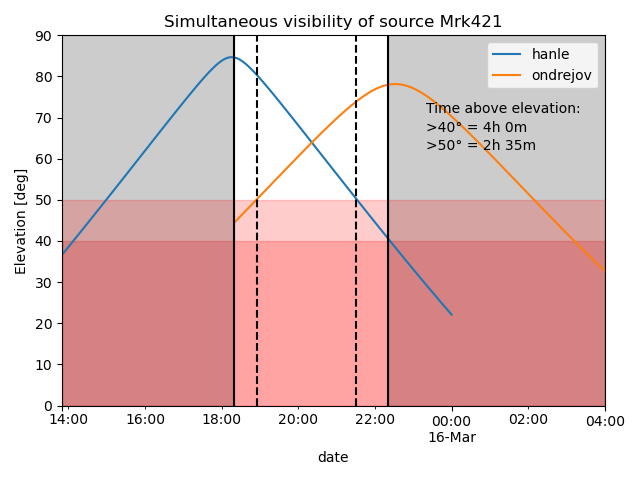

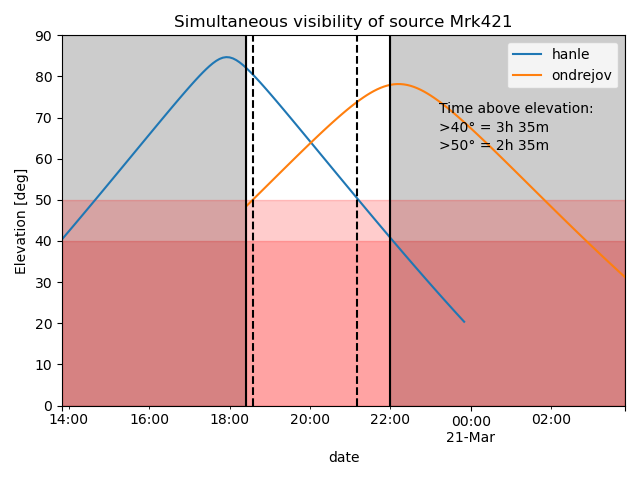

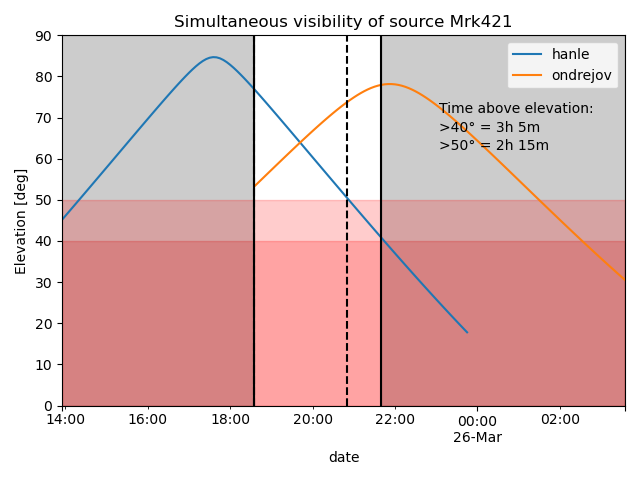

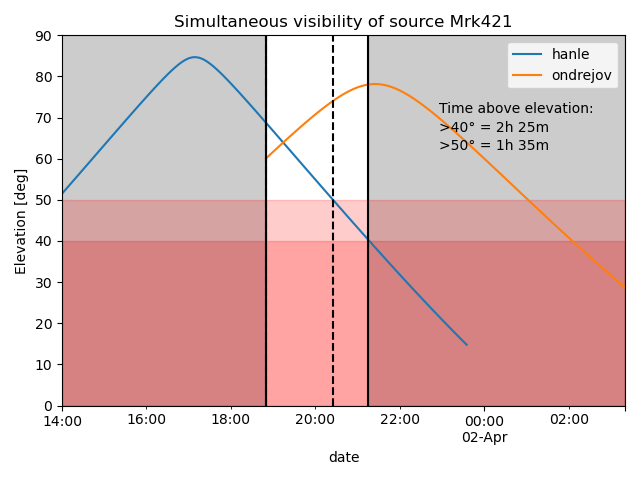

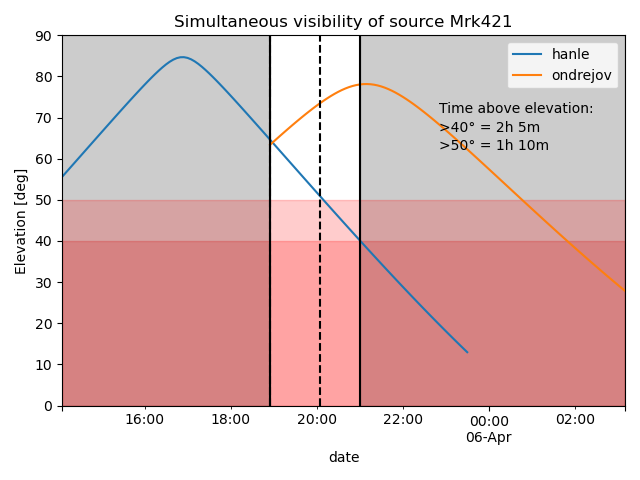

In [57]:
year = 2025
for month in range(1,13):
    for day in [1,5,10,15,20,25]:
        # Run digicam scheduler for beginning of month
        start_date = f"'{year:4d}-{month:02d}-{day:02d} 12:00'"
        end_date = f"'{year:4d}-{month:02d}-{day+1:02d} 12:00'"
        run_digicam_scheduling(start_date, end_date, output_ond, loc_ondrejov, json_file_name, env_ondrejov, time_step=5)
        run_digicam_scheduling(start_date, end_date, output_han, loc_hanle, json_file_name, env_hanle, time_step=5)
        # Read output visibility files
        filename1 = f'{src}{year}-{month:02d}-{day:02d}T12-00-00.000{year}-{month:02d}-{day+1:02d}T12-00-00.000_visibility.csv'
        filename2 = f'{src}_{year}-{month:02d}-{day:02d}T12-00-00.000{year}-{month:02d}-{day+1:02d}T12-00-00.000_visibility.csv'
        try:
            data_ond = read_visibility_csv(output_ond,filename=filename1)
            data_han = read_visibility_csv(output_han,filename=filename1)
        except(FileNotFoundError):
            data_ond = read_visibility_csv(output_ond,filename=filename2)
            data_han = read_visibility_csv(output_han,filename=filename2)
        make_plot(src,data_ond,data_han,year,month,day)
        print(f'{year}-{month}-{day} done')

# Make gif with plot visibility

In [68]:
from PIL import Image
import time
import numpy as np
from pathlib import Path
import os

Path(f'../output/simultaneous_visibility/{src}').mkdir(exist_ok=True)
folder = Path(f'../output/simultaneous_visibility/{src}')

png_list = os.listdir(folder)
png_list.sort()

# create an empty list called images
images = []
images_name = []
for f in png_list:
    if f == '.DS_Store' or f == '.ipynb_checkpoints':
        continue
    n = Path(f'../output/simultaneous_visibility/{src}') / f
    images_name.append(n)

# get all the images in the 'images for gif' folder
for filename in images_name: # loop through all png files in the folder
    im = Image.open(filename) # open the image
    #im_small = im.resize((1200, 1500), resample=0) # resize them to make them a bit smaller
    images.append(im) # add the image to the list

# calculate the frame number of the last frame (ie the number of images)
last_frame = (len(images)) 

# save as a gif   
out = Path(f'../output/simultaneous_visibility/{src}.gif')
images[0].save(out, save_all=True, append_images=images[1:], optimize=False, duration=150, loop=0)